### This aims to classify the exosome staus based on a featureset derrived from the peaks.

Lets test different spectral cleaning parameters

Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

Read the spectral data

In [2]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

In [3]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia


In [4]:
df['SpecID'].unique()

array(['201210-1-00', '201210-1-01', '201210-1-02', ..., '210526-3-07',
       '210526-3-08', '210526-3-09'], dtype=object)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8023575 entries, 0 to 8023574
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   Absorbance  float64
 4   SurID       object 
 5   Status      object 
dtypes: float64(2), int64(1), object(3)
memory usage: 367.3+ MB


#### Train an Extra Trees Classifier on the full spectrum.

In [6]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    statuses = df[['SpecID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [7]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [8]:
wavelength_df.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,2709.3699,2697.1318,2696.0413,2678.5925,2670.8928,2652.5435,2646.3245,2690.3240,2620.3228,2609.0132,...,1100.5006,1088.7416,1092.1083,1104.9304,1084.1281,1076.9363,1089.0814,1092.8083,1086.6990,Normal
201210-1-01,2979.3169,2985.7070,2970.1677,2947.0950,2941.8743,2942.4648,2939.9595,2938.4509,2930.9204,2915.7979,...,1246.2748,1270.4456,1272.1703,1271.8768,1270.0718,1283.9667,1286.9803,1276.4037,1268.0922,Normal
201210-1-02,3702.5627,3592.4902,3640.8423,3593.4150,3583.6560,3583.4790,3554.3279,3507.1514,3494.4998,3490.4370,...,2028.6669,2046.8510,2094.8308,2067.8396,2043.0687,2063.5925,2086.6956,2064.7766,2064.2126,Normal
201210-1-03,8129.5938,8222.3184,8370.2803,8534.4150,8684.1543,8805.7393,8964.5283,9220.3066,9257.7461,9399.7734,...,1682.3824,1694.8450,1710.2760,1714.6768,1746.4635,1705.4204,1703.1569,1705.2943,1687.0480,Normal
201210-1-04,3468.5203,3463.0237,3475.2666,3468.5999,3451.7124,3439.6379,3439.1538,3444.8345,3446.6240,3438.2632,...,1725.4711,1722.2786,1757.0481,1745.6029,1728.0017,1750.2548,1747.0122,1756.1727,1747.9722,Normal


>Train an Extra Trees Classifier on the Raw Spectrum and evaluate it with 10-fold cross validation.

In [9]:
def evaluate_extra_trees(df):
    # Splitting the dataframe into features (X) and target variable (y)
    X = df.drop(['Status'], axis=1)
    y = df['Status']
    
    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using StratifiedKFold for classification tasks
    #cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)

    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [10]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8841 +/- 0.0178


>Scale the absorbances to the highest peak in each spectrum.

In [11]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Scaled_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

In [12]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal,1.000000
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal,0.995483
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal,0.995081
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal,0.988640
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal,0.985799


In [13]:
scaled_raw_df = prepare_wavelength_df(df, 'Scaled_Absorbance')

In [14]:
scaled_raw_df.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1.000000,0.995483,0.995081,0.988640,0.985799,0.979026,0.976731,0.992970,0.967134,0.962959,...,0.406183,0.401843,0.403086,0.407818,0.400140,0.397486,0.401969,0.403344,0.401089,Normal
201210-1-01,0.997860,1.000000,0.994795,0.987068,0.985319,0.985517,0.984678,0.984173,0.981650,0.976585,...,0.417414,0.425509,0.426087,0.425988,0.425384,0.430038,0.431047,0.427505,0.424721,Normal
201210-1-02,1.000000,0.970271,0.983330,0.970521,0.967885,0.967837,0.959964,0.947223,0.943806,0.942708,...,0.547909,0.552820,0.565779,0.558489,0.551799,0.557342,0.563581,0.557661,0.557509,Normal
201210-1-03,0.785427,0.794385,0.808680,0.824538,0.839005,0.850751,0.866092,0.890804,0.894421,0.908143,...,0.162540,0.163745,0.165235,0.165661,0.168732,0.164766,0.164548,0.164754,0.162991,Normal
201210-1-04,0.998059,0.996477,1.000000,0.998082,0.993222,0.989748,0.989609,0.991243,0.991758,0.989352,...,0.496500,0.495582,0.505587,0.502293,0.497229,0.503632,0.502699,0.505335,0.502975,Normal


In [15]:
#scaled_raw_df.to_csv("../../data/scaled_raw_spectra.csv")

In [16]:
evaluate_extra_trees(scaled_raw_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9399 +/- 0.0110


> Now see the effect of spikes caused by cosmic rays

Locate and correct the spikes

In [17]:
def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarisation threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if it has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=10)
    return(despiked_absorbance)

df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [18]:
df  

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal,1.000000,2709.3699
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal,0.995483,2697.1318
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal,0.995081,2696.0413
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal,0.988640,2678.5925
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal,0.985799,2670.8928
...,...,...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia,0.483204,1321.0371
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia,0.481510,1316.4056
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia,0.479629,1311.2640
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia,0.482127,1318.0909


In [19]:
despiked_df = prepare_wavelength_df(df, 'Despiked_Absorbance')

In [20]:
evaluate_extra_trees(despiked_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8801 +/- 0.0172


Despike with scaling.

In [21]:
df['Scaled_Despiked_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: normalise(x))

In [22]:
scaled_despiked_df = prepare_wavelength_df(df, 'Scaled_Despiked_Absorbance')

In [23]:
evaluate_extra_trees(scaled_despiked_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9445 +/- 0.0125


Seems to cause a small degradation to performance.

>Calculate the baseline using Asymmetric Least Squares, then subtract it from the spectrum.

In [24]:
def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# lam = 10 ** 8
# p = 0.05
# df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p))

Here is an example on 1 spectrum

In [25]:
sample = df[df['SpecID'] == "210526-3-06"]
sample

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance,Scaled_Despiked_Absorbance
8013035,210526-3-06,0,200.00000,2931.4734,210526-3,Hyperglycemia,0.946687,2931.4734,0.946687
8013036,210526-3-06,1,200.68336,2966.8181,210526-3,Hyperglycemia,0.958101,2966.8181,0.958101
8013037,210526-3-06,2,201.36674,2998.7166,210526-3,Hyperglycemia,0.968403,2998.7166,0.968403
8013038,210526-3-06,3,202.05011,2976.7317,210526-3,Hyperglycemia,0.961303,2976.7317,0.961303
8013039,210526-3-06,4,202.73349,2962.2146,210526-3,Hyperglycemia,0.956615,2962.2146,0.956615
...,...,...,...,...,...,...,...,...,...
8015665,210526-3-06,2630,1997.26650,1615.7242,210526-3,Hyperglycemia,0.521780,1615.7242,0.521780
8015666,210526-3-06,2631,1997.94980,1596.2550,210526-3,Hyperglycemia,0.515493,1596.2550,0.515493
8015667,210526-3-06,2632,1998.63330,1593.9277,210526-3,Hyperglycemia,0.514742,1593.9277,0.514742
8015668,210526-3-06,2633,1999.31670,1599.9712,210526-3,Hyperglycemia,0.516693,1599.9712,0.516693


/tmp/ipykernel_3688/1363969637.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p, niter=10))


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

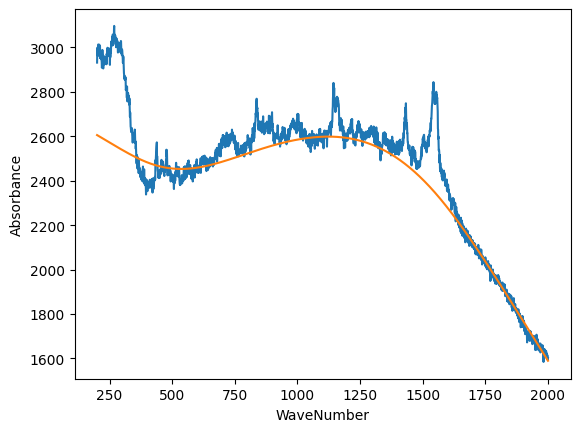

In [26]:
# lam = 10 ** 6
# p = 0.01

# lam = 10 ** 7
# p = 0.05

lam = 10 ** 9
p = 0.1
sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p, niter=10))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)

Subtract the baseline.

/tmp/ipykernel_3688/1303904700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

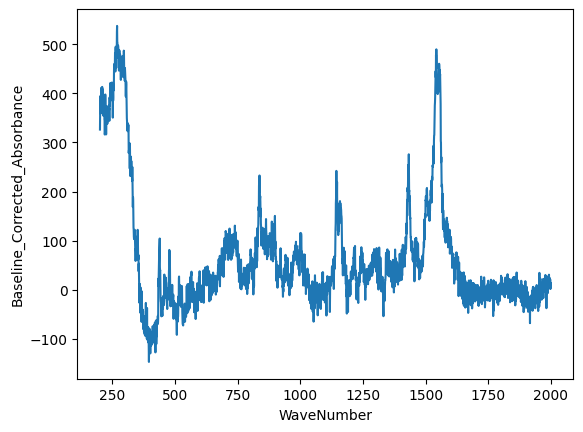

In [27]:
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Remove the noise from the spectra using Savitzky–Golay-filtering on the raw spectrum.

/tmp/ipykernel_4153/4250886446.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

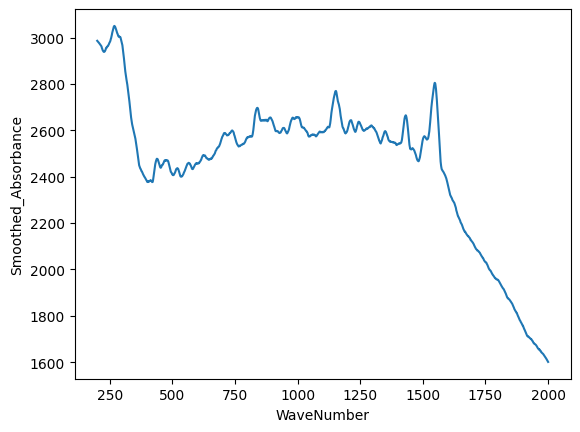

In [43]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

Try it on the Baseline_Corrected_Spectrum

/tmp/ipykernel_4153/1425479424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

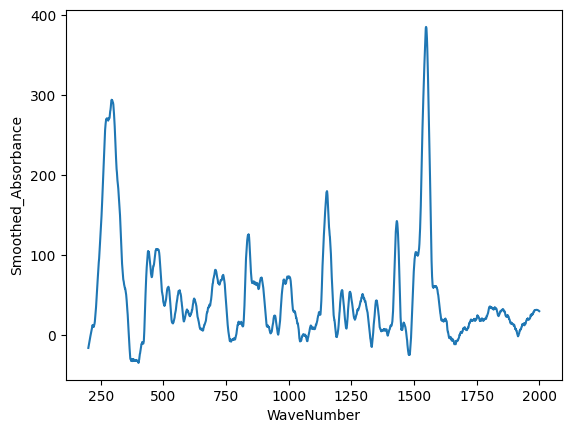

In [44]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

/tmp/ipykernel_4153/1280720429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, 9, 2, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

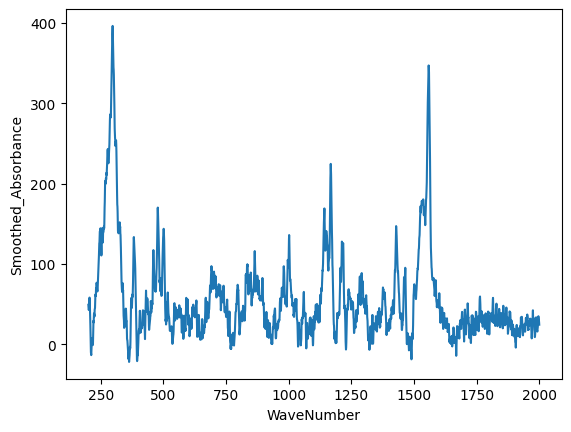

In [30]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, 9, 2, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

>Based on hand tuned parameters lets see how they affect the Machine Learning Classification.

In [46]:
df['Baseline_Corrected_Absorbance'] = df['Absorbance'] - df.groupby('SpecID')['Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p, niter=10))

In [ ]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance,Scaled_Despiked_Absorbance,Baseline_Corrected_Absorbance
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal,1.000000,2709.3699,1.000000,79.710030
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal,0.995483,2697.1318,0.995483,71.406660
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal,0.995081,2696.0413,0.995081,74.250891
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal,0.988640,2678.5925,0.988640,60.736818
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal,0.985799,2670.8928,0.985799,56.971842


In [ ]:
baseline_corrected_df = prepare_wavelength_df(df, 'Baseline_Corrected_Absorbance')

In [33]:
baseline_corrected_df.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,79.710030,71.406660,74.250891,60.736818,56.971842,42.557257,40.272962,88.207153,22.140624,14.765671,...,37.085006,25.681712,29.404111,42.581904,22.135293,15.299180,27.799965,31.882549,26.128933,Normal
201210-1-01,102.931211,113.636694,102.412776,83.655454,82.750126,87.655988,89.466034,92.272760,89.057558,78.250320,...,21.146490,45.527663,47.462720,47.379567,45.784906,59.890139,63.114070,52.747799,44.646628,Normal
201210-1-02,242.709658,138.612956,192.940851,151.489341,147.706118,153.504876,130.329507,89.128698,82.452741,84.365520,...,145.383402,163.368144,211.148535,183.957888,158.987514,179.311821,202.215417,180.096908,179.333397,Normal
201210-1-03,-250.747860,-132.003110,41.979189,232.134914,407.896246,555.504659,740.318826,1022.124413,1085.593680,1253.653576,...,-6.258578,7.153862,23.534696,28.885325,61.621851,21.528576,20.214900,23.302123,6.005647,Normal
201210-1-04,50.336834,49.926660,67.255985,65.675709,53.874629,46.886544,51.488851,62.255946,69.131826,65.857385,...,15.156063,12.789142,48.384210,37.764568,20.988920,44.067568,41.650512,51.636556,44.261598,Normal


In [34]:
evaluate_extra_trees(baseline_corrected_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8844 +/- 0.0186


Scale the Baseline Corrected Absorbances to the highest peak.

In [35]:
df['Scaled_Baseline_Corrected'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: normalise(x))

In [36]:
scaled_baseline_df = prepare_wavelength_df(df, 'Scaled_Baseline_Corrected')

In [37]:
evaluate_extra_trees(scaled_baseline_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8755 +/- 0.0111


> Lets try 2 different Savitsky Golay Approaches on the Raw and Baseline Corrected Spectra with and without scaling

In [38]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [39]:
smooth_df = prepare_wavelength_df(df, 'Smoothed_Absorbance')

In [40]:
evaluate_extra_trees(smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8828 +/- 0.0182


In [41]:
df['Scaled_Smooth'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

In [42]:
scaled_smooth_df = prepare_wavelength_df(df, 'Scaled_Smooth')

In [43]:
evaluate_extra_trees(scaled_smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9412 +/- 0.0135


In [44]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [45]:
smooth_df = prepare_wavelength_df(df, 'Smoothed_Absorbance')

In [46]:
evaluate_extra_trees(smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8765 +/- 0.0160


In [47]:
df['Scaled_Smooth'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

In [48]:
scaled_smooth_df = prepare_wavelength_df(df, 'Scaled_Smooth')

In [49]:
evaluate_extra_trees(scaled_smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9507 +/- 0.0122


Try this on the baseline corrected spectra.

In [50]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [51]:
smooth_baseline = prepare_wavelength_df(df, 'Smoothed_Baseline')

In [52]:
evaluate_extra_trees(smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9100 +/- 0.0191


In [126]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: normalise(x))

In [127]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [128]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9205 +/- 0.0150


In [113]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [114]:
smooth_baseline = prepare_wavelength_df(df, 'Smoothed_Baseline')

In [115]:
evaluate_extra_trees(smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9353 +/- 0.0138


In [116]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: normalise(x))

In [117]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [118]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9241 +/- 0.0142


In [119]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: vector_normalise(x))

In [120]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [121]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9205 +/- 0.0150


----

The negative impact of scaling the unsmoothed baseline is strange.

In [93]:
df['No_Below_Baseline'] = np.where(df['Baseline_Corrected_Absorbance'] < 0, 0, df['Baseline_Corrected_Absorbance'])

In [94]:
no_negative = prepare_wavelength_df(df, 'No_Below_Baseline')

In [95]:
evaluate_extra_trees(no_negative)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8838 +/- 0.0187


Then with scaling.

In [96]:
df['Scaled_No_Below_Baseline'] = np.where(df['Scaled_Baseline_Corrected'] < 0, 0, df['Scaled_Baseline_Corrected'])

In [97]:
scaled_no_negative = prepare_wavelength_df(df, 'Scaled_No_Below_Baseline')

In [98]:
scaled_no_negative.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.309089,0.276892,0.287921,0.235517,0.220918,0.165023,0.156165,0.342038,0.085854,0.057256,...,0.143803,0.099585,0.114020,0.165119,0.085833,0.059325,0.107799,0.123630,0.101319,Normal
201210-1-01,0.427284,0.471724,0.425132,0.347267,0.343509,0.363874,0.371388,0.383039,0.369692,0.324830,...,0.087782,0.188993,0.197025,0.196680,0.190060,0.248614,0.261997,0.218965,0.185335,Normal
201210-1-02,0.157993,0.090231,0.125596,0.098613,0.096150,0.099925,0.084838,0.058019,0.053673,0.054918,...,0.094638,0.106345,0.137448,0.119748,0.103493,0.116724,0.131633,0.117235,0.116738,Normal
201210-1-03,0.000000,0.000000,0.017398,0.096209,0.169053,0.230230,0.306827,0.423621,0.449926,0.519579,...,0.000000,0.002965,0.009754,0.011972,0.025539,0.008923,0.008378,0.009658,0.002489,Normal
201210-1-04,0.131023,0.129955,0.175062,0.170949,0.140232,0.122042,0.134022,0.162048,0.179945,0.171422,...,0.039450,0.033289,0.125940,0.098298,0.054633,0.114705,0.108413,0.134406,0.115210,Normal


In [99]:
evaluate_extra_trees(scaled_no_negative)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8801 +/- 0.0166


Try Min-Max Scaling Instead

In [100]:
def min_max_scale(absorbances):
    min_value = np.min(absorbances)
    max_value = np.max(absorbances)
    return (absorbances - min_value) / (max_value - min_value)

df['MinMax_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: min_max_scale(x))

In [101]:
min_max_raw_df = prepare_wavelength_df(df, 'MinMax_Absorbance')

In [102]:
evaluate_extra_trees(min_max_raw_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9399 +/- 0.0082


In [103]:
df['MinMax_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: min_max_scale(x))

In [104]:
min_max_baseline_df = prepare_wavelength_df(df, 'MinMax_Baseline')

In [105]:
min_max_baseline_df.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.391105,0.362730,0.372449,0.326267,0.313400,0.264141,0.256334,0.420143,0.194369,0.169167,...,0.245440,0.206471,0.219191,0.264225,0.194351,0.170990,0.213709,0.227661,0.207999,Normal
201210-1-01,0.514701,0.552358,0.512877,0.446898,0.443713,0.460970,0.467337,0.477210,0.465900,0.427885,...,0.227020,0.312782,0.319588,0.319296,0.313686,0.363302,0.374643,0.338179,0.309682,Normal
201210-1-02,0.187571,0.122190,0.156312,0.130277,0.127901,0.131543,0.116987,0.091109,0.086916,0.088118,...,0.126442,0.137738,0.167748,0.150670,0.134987,0.147752,0.162138,0.148245,0.147766,Normal
201210-1-03,0.000000,0.044581,0.109900,0.181291,0.247278,0.302696,0.372082,0.477882,0.501710,0.564806,...,0.091790,0.096825,0.102975,0.104984,0.117275,0.102222,0.101729,0.102888,0.096394,Normal
201210-1-04,0.202215,0.201235,0.242646,0.238870,0.210669,0.193970,0.204968,0.230698,0.247129,0.239304,...,0.118145,0.112488,0.197549,0.172172,0.132083,0.187234,0.181458,0.205321,0.187697,Normal


In [106]:
evaluate_extra_trees(min_max_baseline_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8683 +/- 0.0224


This is worse, lets try vector normalisation, where the spectra are scaled by their euclidean norm.

In [107]:
def vector_normalise(absorbances):
    l2_norm = np.sqrt(np.sum(absorbances**2))  # Calculate the euclidean norm
    normalized_absorbances = absorbances / l2_norm
    return normalized_absorbances

df['Vector_Scaled_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: vector_normalise(x))

In [108]:
vector_scale_raw = prepare_wavelength_df(df, "Vector_Scaled_Absorbance")

In [109]:
evaluate_extra_trees(vector_scale_raw)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9465 +/- 0.0091


Try on the baseline corrected spectra.

In [110]:
df['Vector_Scaled_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: vector_normalise(x))

In [111]:
vector_scale_baseline = prepare_wavelength_df(df, 'Vector_Scaled_Baseline')

In [112]:
evaluate_extra_trees(vector_scale_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8696 +/- 0.0128
